In [33]:
import sklearn

In [34]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples=n_samples,
                   noise=0.03,
                   random_state=42)

In [35]:
len(X), len(y)

(1000, 1000)

In [36]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [37]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [38]:
from matplotlib import pyplot as plt

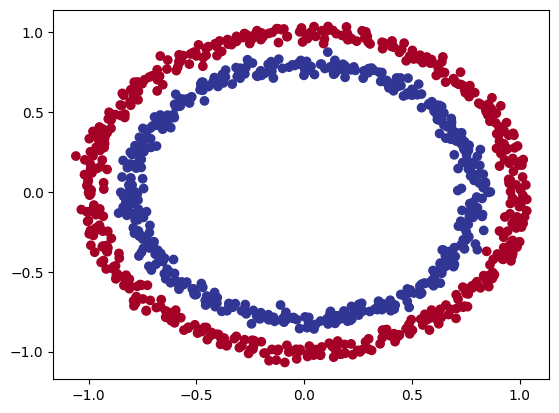

In [39]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [40]:
X.shape, y.shape

((1000, 2), (1000,))

In [41]:
import torch

In [42]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
len(X_train), len(y_train)

(800, 800)

In [45]:
len(X_test), len(y_test)

(200, 200)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
from torch import nn

In [48]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) #x goes into layer 1 then into layer 2
model = CircleModelV1().to(device)
model

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [49]:
next(model.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True)

In [50]:
#replicate the model
model = nn.Sequential(
    nn.Linear(in_features=2,out_features=4),
    nn.Linear(in_features=4,out_features=8),
    nn.Linear(in_features=8,out_features=16),
    nn.Linear(in_features=16,out_features=1),
).to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=8, bias=True)
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): Linear(in_features=16, out_features=1, bias=True)
)

In [51]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6984,  0.6386, -0.6007,  0.5459], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0832, -0.1624,  0.3090,  0.0779],
                      [ 0.4040,  0.0547, -0.1577,  0.1343],
                      [-0.1356,  0.2104,  0.4464,  0.2890],
                      [-0.2186,  0.2886,  0.0895,  0.2539],
                      [-0.3048, -0.4950, -0.1932, -0.3835],
                      [ 0.4103,  0.1440,  0.2071,  0.1581],
                      [-0.0087,  0.3913, -0.3553,  0.0315],
                      [-0.3413,  0.1542, -0.1722,  0.1532]], device='cuda:0')),
             ('1.bias',
              tensor([-0.1042,  0.4147, -0.2964, -0.2982, -0.2982,  0.4497,  0.1666,  0.4811],
                     device='cuda:0')),

In [52]:
untrained_preds = model(X_test.to(device))
print(f"untrained preds: {len(untrained_preds)} shape: {untrained_preds.shape}")

untrained preds: 200 shape: torch.Size([200, 1])


In [53]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [54]:
def acuracy(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [55]:
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=8, bias=True)
  (2): Linear(in_features=8, out_features=16, bias=True)
  (3): Linear(in_features=16, out_features=1, bias=True)
)

In [56]:
torch.cuda.manual_seed(42)

epochs = 20000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = acuracy(y_true=-y_train,
                  y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = acuracy(y_true=y_test,y_pred=test_pred)

    # if epoch % 10 == 0:
    #     print(f"epoch: {epoch}, loss: {loss}, acc: {test_acc}, test_loss: {test_loss}")

In [57]:
print(f"epoch: {epoch}, loss: {loss}, acc: {test_acc}, test_loss: {test_loss}")

epoch: 19999, loss: 0.6939019560813904, acc: 53.5, test_loss: 0.6916768550872803


In [58]:
import requests
from pathlib import Path

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [59]:
from helper_functions import plot_decision_boundary, plot_predictions

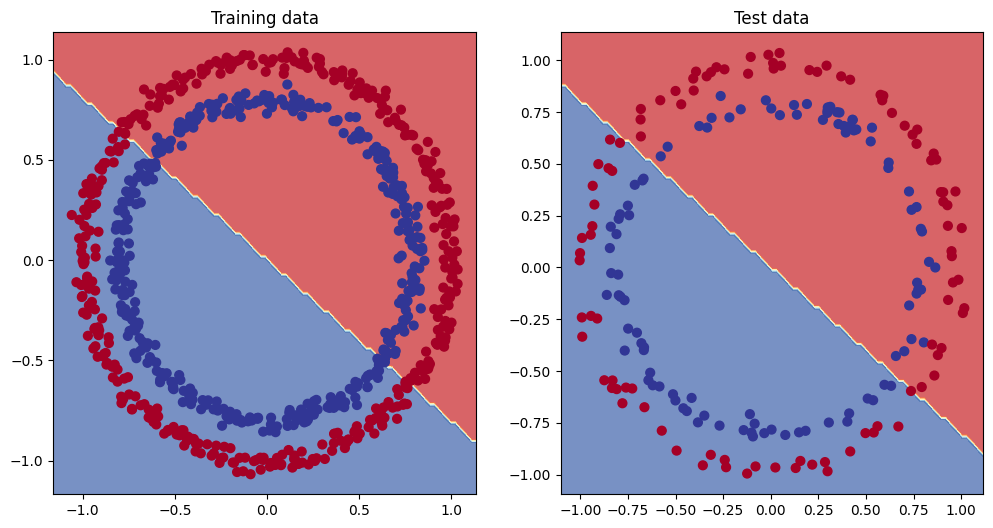

In [60]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training data")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test data")
plot_decision_boundary(model, X_test, y_test)

In [61]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV2().to(device)
model_1

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [62]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [63]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = acuracy(y_true=y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_1.eval()
    with torch.no_grad():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = acuracy(y_true=y_test,y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"epoch: {epoch}, loss: {loss}, acc: {test_acc}, test_loss: {test_loss}")

epoch: 0, loss: 0.6995629668235779, acc: 50.0, test_loss: 0.703170657157898
epoch: 100, loss: 0.6938064694404602, acc: 50.0, test_loss: 0.6954665780067444
epoch: 200, loss: 0.6931694149971008, acc: 48.5, test_loss: 0.6948097348213196
epoch: 300, loss: 0.6930272579193115, acc: 46.5, test_loss: 0.6947022080421448
epoch: 400, loss: 0.692992091178894, acc: 47.5, test_loss: 0.694681704044342
epoch: 500, loss: 0.6929830312728882, acc: 47.0, test_loss: 0.6946783065795898
epoch: 600, loss: 0.6929806470870972, acc: 46.0, test_loss: 0.6946783065795898
epoch: 700, loss: 0.6929801106452942, acc: 46.0, test_loss: 0.694678783416748
epoch: 800, loss: 0.6929798722267151, acc: 44.5, test_loss: 0.6946790814399719
epoch: 900, loss: 0.6929798722267151, acc: 45.0, test_loss: 0.6946793794631958


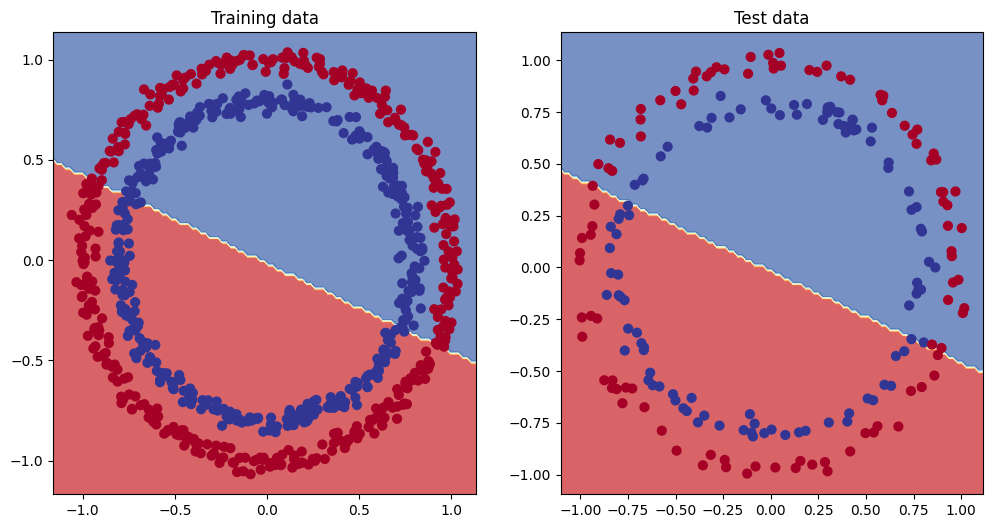

In [64]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test data")
plot_decision_boundary(model_1, X_test, y_test)